# Project Time Series model of Air Passengers

#### Dataset:

The dataset contains time series data of number of Air Passengers travelled starting from 1949 to 1960. The interval of the data is monthly that means for each month total passengers count is available

#### Objective:

The objective is to develop a time series model to predict demand forecast of future.

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------#

#### -Import Packages

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

#### -Load Dataset

In [30]:
df_airpass=pd.read_csv(r'C:\Users\ohm\Downloads\Machine Learning Exercises\timeseries/AirPassengers.csv',parse_dates=[0],index_col=0,header=0,names=['month','passenger'])
df_airpass.head().append(df_airpass.tail())

,passenger
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


In [31]:
df_airpass.dtypes           #datatype

passenger    int64
dtype: object

In [32]:
df_airpass.shape        #table size

(144, 1)

In [33]:
len(df_airpass.passenger)

144

#### -Understand the distribution

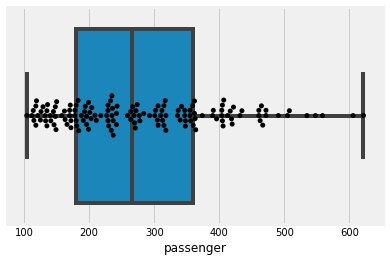

In [34]:
import seaborn as sns
sns.boxplot(df_airpass.passenger)
sns.swarmplot(df_airpass.passenger,color='black')

#### -Lets plot the data

Text(0.5,0,'Year')

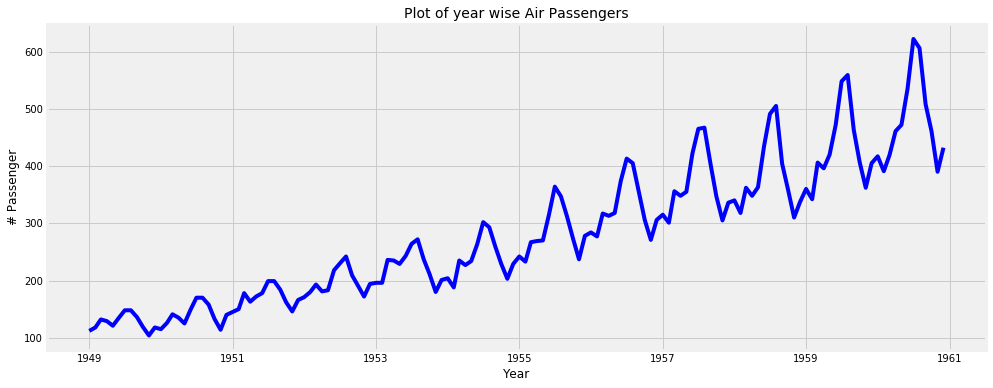

In [35]:
rcParams['figure.figsize']=15,6
plt.plot(df_airpass.passenger,'b')
plt.title('Plot of year wise Air Passengers',fontsize=14)
plt.ylabel('# Passenger')
plt.xlabel('Year')

#### -Let us try to decompose the componets of the time series in to trend, seasonality and randomness

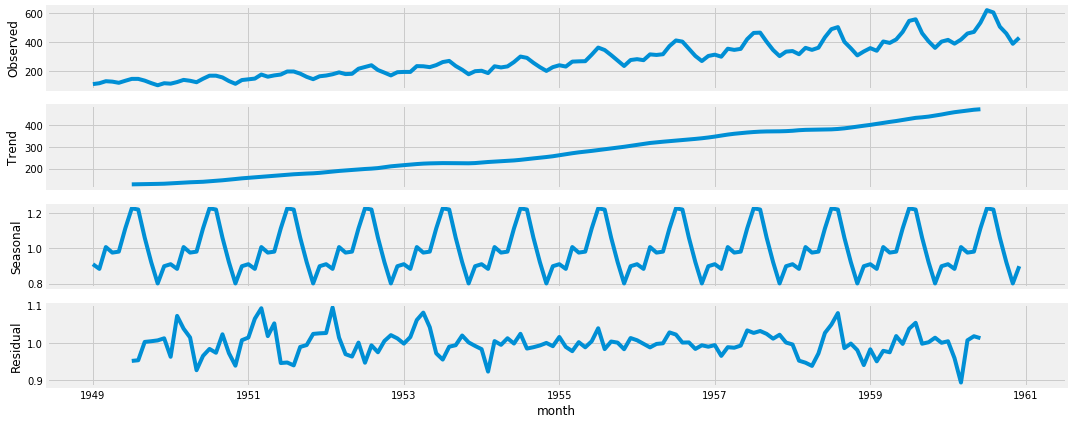

In [36]:
decomposition=seasonal_decompose(df_airpass.passenger,model='multiplicative')       #Decompose using multiplicative 
decomposition.plot()
#plt.title('Decomposed Time Series')
plt.show()

#### -Lets apply log normalisation

The variance in the time series start point to end point is not constant, hence applying log normalisation the variability could be optimised

Text(0.5,1,'Log normalised time series of Air Passengers')

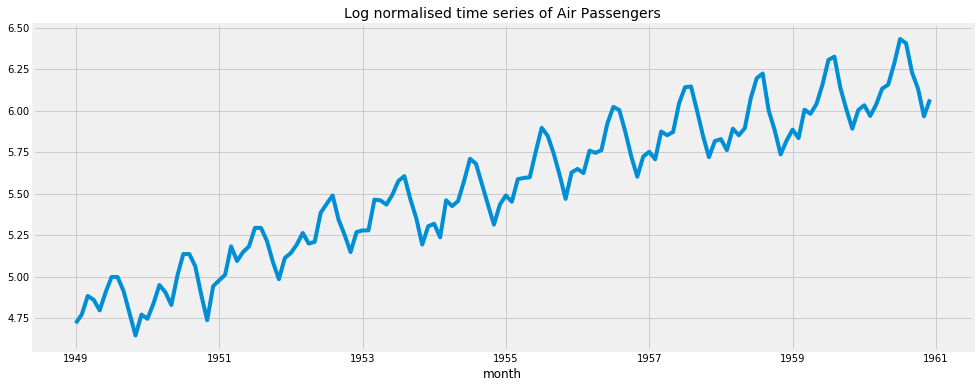

In [37]:
log_passenger=np.log(df_airpass.passenger)              #Apply log normalisation
log_passenger.plot()
plt.title('Log normalised time series of Air Passengers',fontsize=14)

#### -Let us try to remove the trend part from the data to make the series stationary

In [38]:
# 1st order differentiation applied
log_passenger_diff=log_passenger-log_passenger.shift(1)
log_passenger_diff.head()

month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: passenger, dtype: float64

In [39]:
# Drop the 1st row
log_passenger_diff.dropna(inplace=True)
log_passenger_diff.head()

month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
Name: passenger, dtype: float64

Text(0.5,1,'Stationary series after Log normalisation and 1st order differentiation')

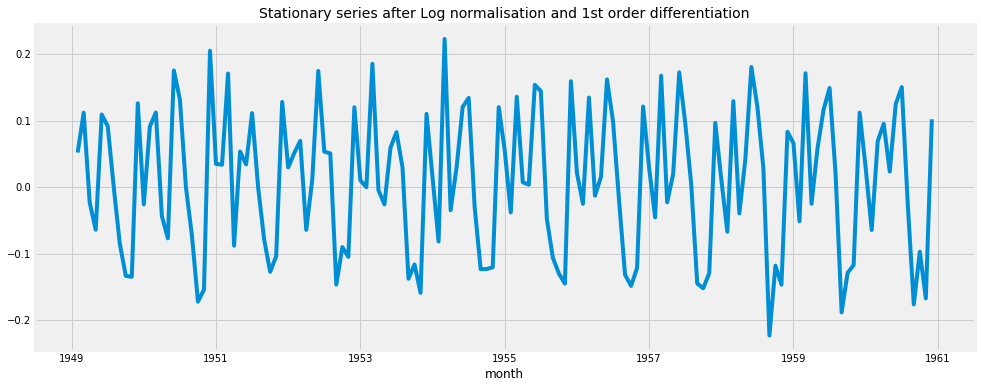

In [40]:
#Plot the data after log normalisation and 1st order differentiation, trend should be removed
log_passenger_diff.plot()
plt.title('Stationary series after Log normalisation and 1st order differentiation',fontsize=14)

### Dickey-Fuller test:

From the above figure the series now seems to be stationary, but to confirm we will do Dickey-Fuller test.

**Null** hypothesis is time series in **NOT stationary**

**Alternate** hypothesis is time series is **stationary**

If the test statistics value is greater than critical value then we will reject the null hypothesis

In [41]:
from statsmodels.tsa.stattools import adfuller    #import dickey fuller test module

In [42]:
#Create a function for the test

def test_stationary(timeseries):
    
    #Create rolling statistics
    rolling_mean=timeseries.rolling(window=12,center=False).mean()
    rolling_std=timeseries.rolling(window=12, center=False).std()
    
    #plot 
    org=plt.plot(timeseries,color='blue',label='Originial')
    mean=plt.plot(rolling_mean,color='red',label='Rolling Mean')
    std=plt.plot(rolling_std,color='black',label='Rolling Std dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation',fontsize=14)
    plt.show()
    
    #Dickey fuller test
    dcf_test=adfuller(timeseries,autolag='AIC')
    df_dcf_test=pd.Series(data=dcf_test[0:4],index=['Test statistic','pvalue','Number of lags used','Number of observations'])
    for key,value in dcf_test[4].items():
        df_dcf_test['Critical Value:(%s)'%key]=value
    print(df_dcf_test)
    #return test_stationary

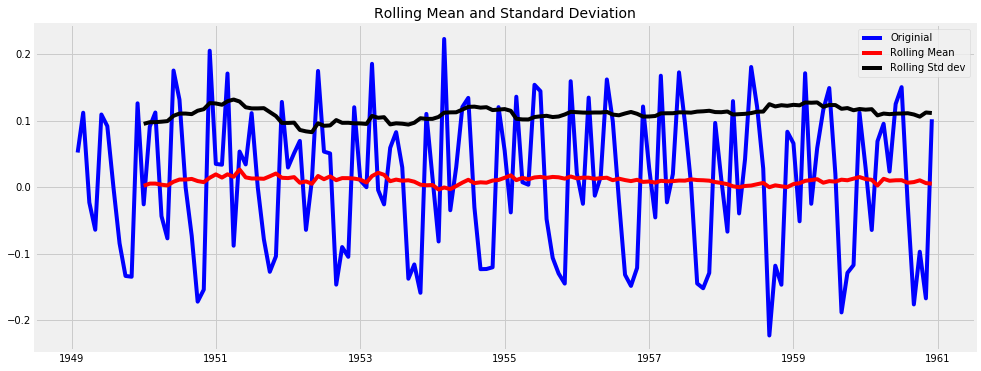

Test statistic             -2.717131
pvalue                      0.071121
Number of lags used        14.000000
Number of observations    128.000000
Critical Value:(1%)        -3.482501
Critical Value:(5%)        -2.884398
Critical Value:(10%)       -2.578960
dtype: float64


In [43]:
test_stationary(log_passenger_diff)

#### Result: 

The test statistic value is greater critical value at 5%, hence at 5% critical value null hypothesis is rejected. This means that **time series is stationary**

### ARIMA:

#### Lets us try to implement Auto Regressive Integrated Moving Average Model

1. Number of Auto Regressive terms (p)
2. Number of Moving average terms (q)
3. Number of differences taken (d)


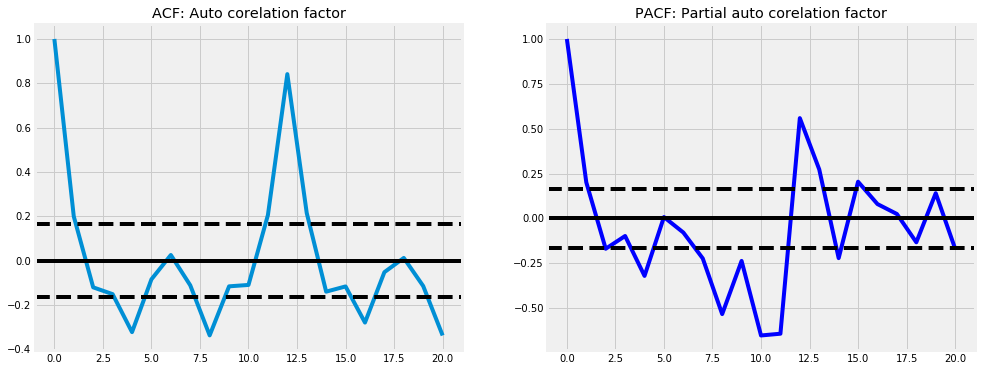

In [44]:
from statsmodels.tsa.stattools import acf,pacf       #import acf pcf

lag_acf=acf(log_passenger_diff.values,nlags=20)
lag_pacf=pacf(log_passenger_diff.values,nlags=20)

plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plt.plot(lag_acf)
plt.title('ACF: Auto corelation factor')
plt.axhline(0,linestyle='-',color='black')
plt.axhline(y=-1.96/np.sqrt(len(log_passenger_diff)),color='black', linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_passenger_diff)),color='black', linestyle='--')
plt.subplot(1,2,2)
plt.plot(lag_pacf,color='blue')
plt.title('PACF: Partial auto corelation factor')
plt.axhline(0,linestyle='-',color='black')
plt.axhline(y=-1.96/np.sqrt(len(log_passenger_diff)),color='black', linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_passenger_diff)),color='black', linestyle='--')

#### Determination of p and q value:

1. The **ACF** plot passes UCL first time at close to value 2, so the **q-value is 2**

2. The **PACF** plot passes UCL first time at close to value 2, so the **P-value is 2**

#### AR Model: (Auto Regressive Model)

In [45]:
from statsmodels.tsa.arima_model import ARIMA        #import arima model package

Text(0.5,1,'Auto Regressive Model, RSS:1.502303')

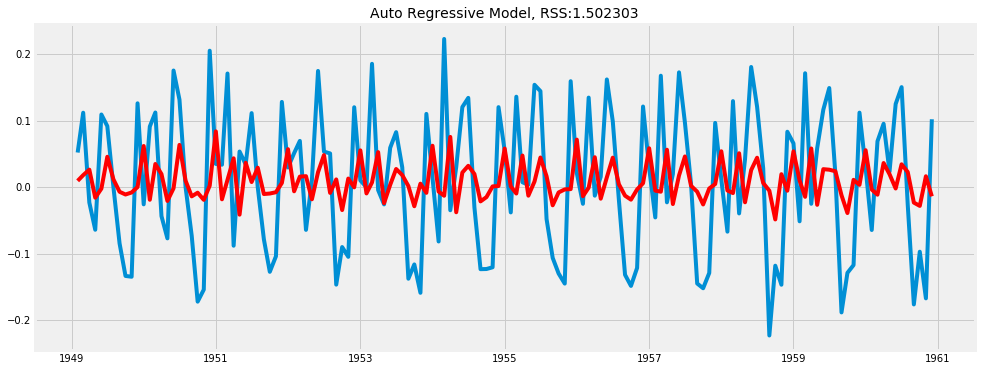

In [46]:
AR_model=ARIMA(log_passenger,order=(2,1,0))        #ARIMA does one level of differentiation, so without diff log passed
AR_results=AR_model.fit(disp=-1)
plt.plot(log_passenger_diff)
plt.plot(AR_results.fittedvalues,color='r')

plt.title('Auto Regressive Model, RSS:%2f'%sum((AR_results.fittedvalues-log_passenger_diff)**2),fontsize=14)



#### MA model: (Moving Average Model)

Text(0.5,1,'Moving Average Model, RSS:1.472140')

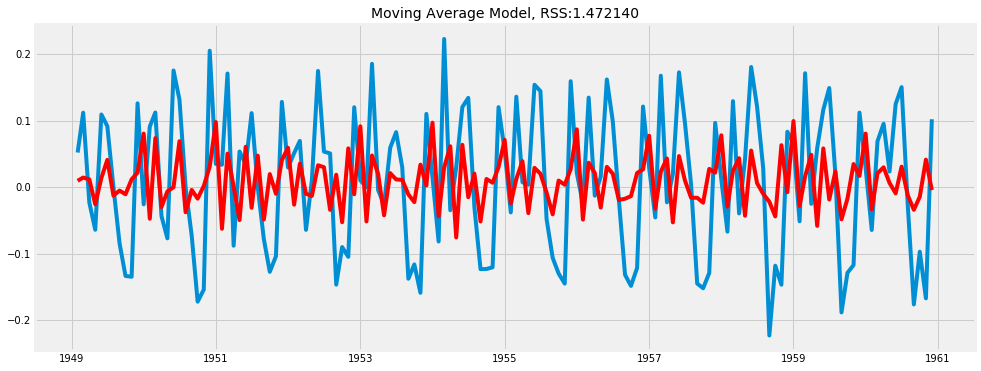

In [47]:
MA_model=ARIMA(log_passenger,order=(0,1,2))
MA_results=MA_model.fit(disp=-1)
plt.plot(log_passenger_diff)
plt.plot(MA_results.fittedvalues,color='r')
plt.title('Moving Average Model, RSS:%4f'%sum((MA_results.fittedvalues-log_passenger_diff)**2),fontsize=14)




#### ARIMA Model:

Text(0.5,1,'ARIMA model, RSS:1.029152')

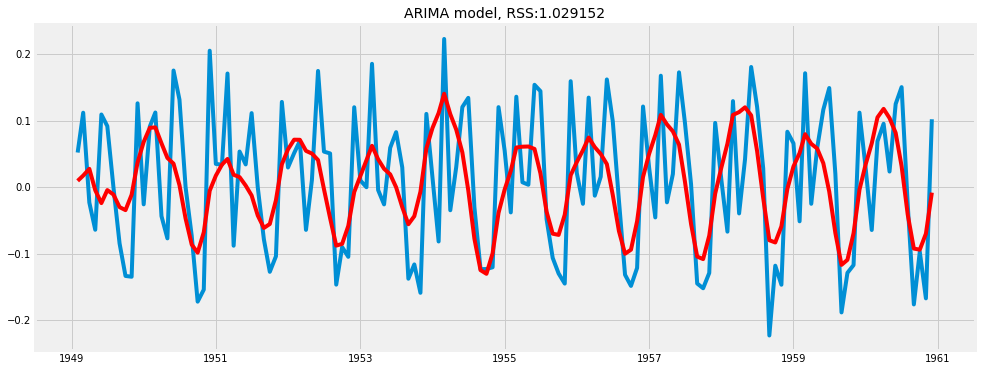

In [48]:
ARIMA_model=ARIMA(log_passenger,order=(2,1,2))        #p=2,d=1,q=2
ARIMA_results=ARIMA_model.fit(disp=-1)
plt.plot(log_passenger_diff)
plt.plot(ARIMA_results.fittedvalues,color='r')
plt.title('ARIMA model, RSS:%4f'%sum((ARIMA_results.fittedvalues-log_passenger_diff)**2),fontsize=14)

##### ARIMA model looks a good fit and it follows the data in stationary condition

#### Prediction using ARIMA model

In [49]:
pred_ARIMA_diff=ARIMA_results.fittedvalues           #Assing the predicted values
pred_ARIMA_diff.head()

month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [50]:
pred_ARIMA_diff_cum=np.cumsum(pred_ARIMA_diff)              ##Cumulative value
pred_ARIMA_diff_cum.head()

month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [51]:
pred_ARIMA_log=pd.Series(log_passenger.iloc[0],index=log_passenger.index)      #Dummy series with first value actual value
pred_ARIMA_log=pred_ARIMA_log.add(pred_ARIMA_diff_cum,fill_value=0)           #add prediced value
pred_ARIMA_log.sample(10)

month
1960-03-01    5.796704
1956-05-01    5.419619
1951-01-01    4.799780
1960-12-01    5.826639
1953-02-01    4.872374
1954-02-01    5.147035
1954-04-01    5.397712
1952-10-01    4.879909
1954-08-01    5.454540
1951-12-01    4.756272
dtype: float64

Text(0.5,0,'Year')

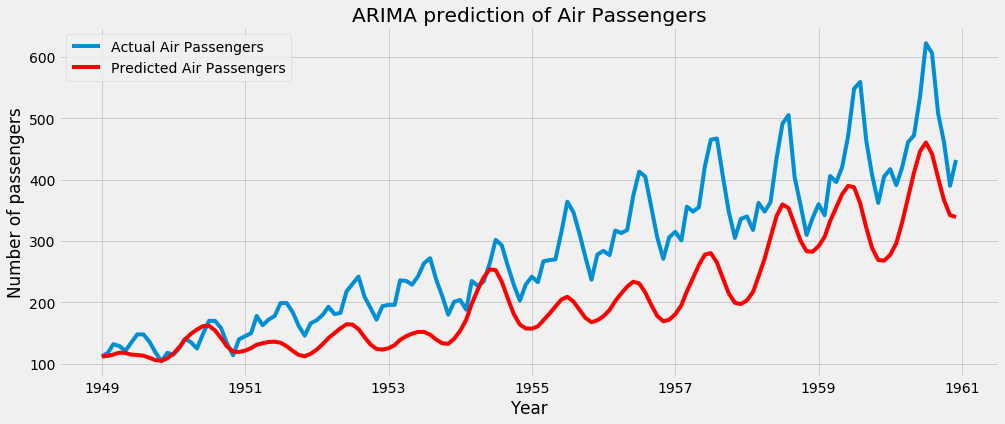

In [52]:
#### Plot the ARIMA predicted and actual value
plt.style.use('fivethirtyeight')
pred_ARIMA=np.exp(pred_ARIMA_log)      #remove log by exponential function
plt.plot(df_airpass.passenger,label='Actual Air Passengers')
plt.plot(pred_ARIMA,color='r',label='Predicted Air Passengers')
plt.legend(loc='best')
plt.title('ARIMA prediction of Air Passengers')
plt.ylabel('Number of passengers')
plt.xlabel('Year')

### Conclusion:

After applying different time series model for Air Passenger data, it has found that **ARIMA model** is giving the **best result and close to actual values.**